In [ ]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt

In [9]:
def get_data(stocks, start, end):
    """
    Fetches historical data, calculates daily returns, 
    and returns mean returns and the covariance matrix.
    """
    # Use yfinance to download data directly
    stockData = yf.download(stocks, start=start, end=end)['Close']
    
    # Calculate daily percentage change and drop the first NaN row
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

C:\Users\kkzeng\AppData\Local\Temp\ipykernel_26496\2443818565.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockData = yf.download(stocks, start=start, end=end)['Close']
[*********************100%***********************]  6 of 6 completed


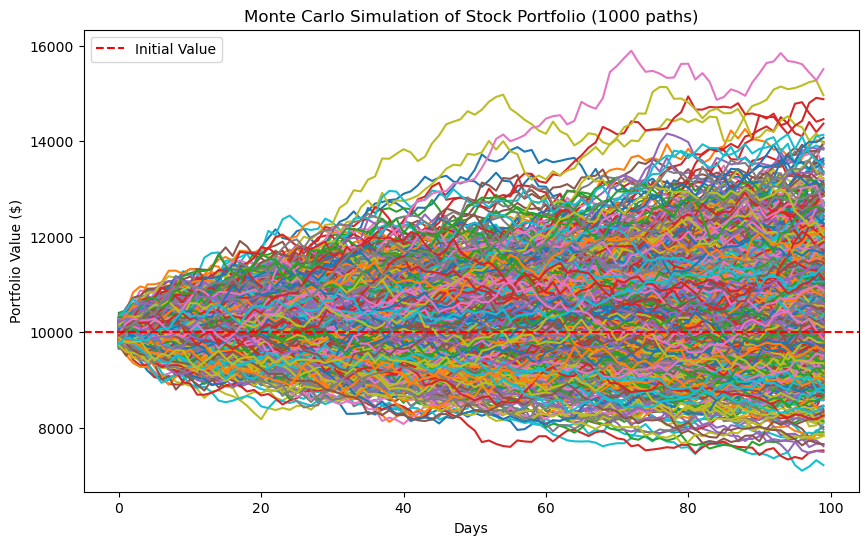

--- Simulation Results (95% Confidence) ---
VaR (Value at Risk): $1254.41
CVaR (Conditional VaR): $1752.99


In [10]:
# 1. Initialization
stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList] # Adding .AX for Australian Stock Exchange
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)

meanReturns, covMatrix = get_data(stocks, startDate, endDate)

# 2. Portfolio Weights
# Generate random weights and normalize them to sum to 1
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

# 3. Monte Carlo Parameters
mc_sims = 1000       # Increased number of simulations for better stability
T = 100              # Timeframe in days
initialPortfolio = 10000

# Prepare Mean Returns Matrix (stocks x days)
# We tile the mean returns to match the dimensions of our random noise
meanM = np.tile(meanReturns, (T, 1)).T 

# Initialize simulation results container (days x simulations)
portfolio_sims = np.zeros((T, mc_sims))

# Cholesky Decomposition
# This transforms uncorrelated random variables into correlated variables 
# based on historical asset correlations.
L = np.linalg.cholesky(covMatrix)

for m in range(mc_sims):
    # Z is (days x stocks) of uncorrelated random normal noise
    Z = np.random.normal(size=(T, len(weights)))
    
    # Calculate daily correlated returns: (stocks x days)
    # dailyReturns = Mean + (L * Z_transpose)
    dailyReturns = meanM + np.dot(L, Z.T)
    
    # Portfolio daily return is the weighted sum of individual stock returns
    portfolio_daily_returns = np.dot(weights, dailyReturns)
    
    # Calculate the cumulative product to simulate the portfolio value over time
    portfolio_sims[:, m] = np.cumprod(portfolio_daily_returns + 1) * initialPortfolio

# 4. Visualization
plt.figure(figsize=(10,6))
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title(f'Monte Carlo Simulation of Stock Portfolio ({mc_sims} paths)')
plt.axhline(initialPortfolio, color='r', linestyle='--', label='Initial Value')
plt.legend()
plt.show()

# 5. Risk Metrics Calculation (VaR & CVaR)
# We focus on the results at the final day (Day 100)
portResults = pd.Series(portfolio_sims[-1, :])

def mcVaR(returns, alpha=5):
    """Value at Risk: The loss level that will not be exceeded with (100-alpha)% confidence"""
    return np.percentile(returns, alpha)

def mcCVaR(returns, alpha=5):
    """Conditional VaR: The average loss given that the loss exceeds the VaR threshold"""
    cutoff = mcVaR(returns, alpha)
    return returns[returns <= cutoff].mean()

# Subtracting the predicted value from initial portfolio to get the "Loss" amount
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print(f"--- Simulation Results (95% Confidence) ---")
print(f"VaR (Value at Risk): ${round(VaR, 2)}")
print(f"CVaR (Conditional VaR): ${round(CVaR, 2)}")